In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e2/sample_submission.csv
/kaggle/input/playground-series-s5e2/train.csv
/kaggle/input/playground-series-s5e2/test.csv
/kaggle/input/playground-series-s5e2/training_extra.csv


# Import Lib

In [1]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb


# Dataset

In [2]:
train_data = pd.read_csv("/kaggle/input/playground-series-s5e2/train.csv")
test_data = pd.read_csv("/kaggle/input/playground-series-s5e2/test.csv")
# original_data = pd.read_csv('/kaggle/input/student-bag-price-prediction-dataset/Noisy_Student_Bag_Price_Prediction_Dataset.csv')
print(train_data.head())
print(test_data.head())
# print(original_data.head())

   id         Brand Material    Size  Compartments Laptop Compartment  \
0   0      Jansport  Leather  Medium           7.0                Yes   
1   1      Jansport   Canvas   Small          10.0                Yes   
2   2  Under Armour  Leather   Small           2.0                Yes   
3   3          Nike    Nylon   Small           8.0                Yes   
4   4        Adidas   Canvas  Medium           1.0                Yes   

  Waterproof      Style  Color  Weight Capacity (kg)      Price  
0         No       Tote  Black             11.611723  112.15875  
1        Yes  Messenger  Green             27.078537   68.88056  
2         No  Messenger    Red             16.643760   39.17320  
3         No  Messenger  Green             12.937220   80.60793  
4        Yes  Messenger  Green             17.749338   86.02312  
       id   Brand Material    Size  Compartments Laptop Compartment  \
0  300000    Puma  Leather   Small           2.0                 No   
1  300001    Nike   Can

# Analysis of dataset

In [8]:
num_train_rows, num_train_columns = train_data.shape

num_test_rows, num_test_columns = test_data.shape



print("Training Data:")
print(f"Number of Rows: {num_train_rows}")
print(f"Number of Columns: {num_train_columns}\n")

print("Test Data:")
print(f"Number of Rows: {num_test_rows}")
print(f"Number of Columns: {num_test_columns}\n")



Training Data:
Number of Rows: 300000
Number of Columns: 11

Test Data:
Number of Rows: 200000
Number of Columns: 10



In [9]:
# Creating a table for missing values, unique values and data types of the features

missing_values_train = pd.DataFrame({'Feature': train_data.columns,
                              '[TRAIN] No. of Missing Values': train_data.isnull().sum().values,
                              '[TRAIN] % of Missing Values': ((train_data.isnull().sum().values)/len(train_data)*100)})

missing_values_test = pd.DataFrame({'Feature': test_data.columns,
                             '[TEST] No.of Missing Values': test_data.isnull().sum().values,
                             '[TEST] % of Missing Values': ((test_data.isnull().sum().values)/len(test_data)*100)})

# missing_values_original = pd.DataFrame({'Feature': original_data.columns,
#                              '[ORIGINAL] No.of Missing Values': original_data.isnull().sum().values,
#                              '[ORIGINAL] % of Missing Values': ((original_data.isnull().sum().values)/len(original_data)*100)})

unique_values = pd.DataFrame({'Feature': train_data.columns,
                              'No. of Unique Values[FROM TRAIN]': train_data.nunique().values})

feature_types = pd.DataFrame({'Feature': train_data.columns,
                              'DataType': train_data.dtypes})

merged_df = pd.merge(missing_values_train, missing_values_test, on='Feature', how='left')
# merged_df = pd.merge(merged_df, missing_values_original, on='Feature', how='left')
merged_df = pd.merge(merged_df, unique_values, on='Feature', how='left')
merged_df = pd.merge(merged_df, feature_types, on='Feature', how='left')

merged_df

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,Feature,[TRAIN] No. of Missing Values,[TRAIN] % of Missing Values,[TEST] No.of Missing Values,[TEST] % of Missing Values,No. of Unique Values[FROM TRAIN],DataType
0,id,0,0.000000,0.0,0.0000,300000,int64
1,Brand,9705,3.235000,6227.0,3.1135,5,object
2,Material,8347,2.782333,5613.0,2.8065,4,object
3,Size,6595,2.198333,4381.0,2.1905,3,object
4,Compartments,0,0.000000,0.0,0.0000,10,float64
5,Laptop Compartment,7444,2.481333,4962.0,2.4810,2,object
6,Waterproof,7050,2.350000,4811.0,2.4055,2,object
7,Style,7970,2.656667,5153.0,2.5765,3,object
8,Color,9950,3.316667,6785.0,3.3925,6,object
9,Weight Capacity (kg),138,0.046000,77.0,0.0385,181596,float64


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


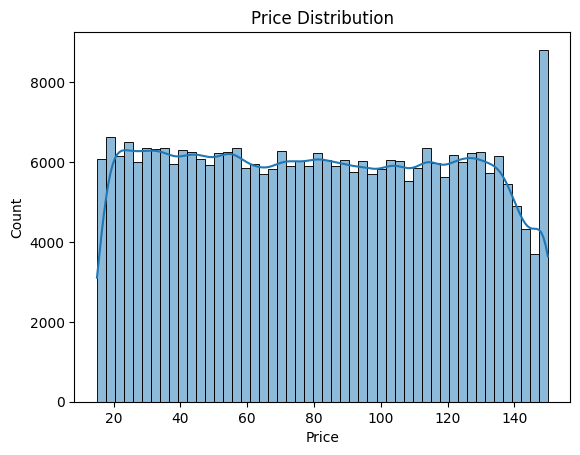

In [10]:
# Checking for missing values
train_data.isnull().sum()

# Descriptive statistics
train_data.describe()

# Visualize the distribution of the target variable (Price)
sns.histplot(train_data['Price'], bins=50, kde=True)
plt.title('Price Distribution')
plt.show()


In [11]:
list(train_data)

['id',
 'Brand',
 'Material',
 'Size',
 'Compartments',
 'Laptop Compartment',
 'Waterproof',
 'Style',
 'Color',
 'Weight Capacity (kg)',
 'Price']

In [12]:
print(train_data.isnull().sum())
print(test_data.isnull().sum())


id                         0
Brand                   9705
Material                8347
Size                    6595
Compartments               0
Laptop Compartment      7444
Waterproof              7050
Style                   7970
Color                   9950
Weight Capacity (kg)     138
Price                      0
dtype: int64
id                         0
Brand                   6227
Material                5613
Size                    4381
Compartments               0
Laptop Compartment      4962
Waterproof              4811
Style                   5153
Color                   6785
Weight Capacity (kg)      77
dtype: int64


In [13]:
# train_data.fillna(train_data.mode().iloc[0], inplace=True)
# test_data.fillna(test_data.mode().iloc[0], inplace=True)


In [14]:
# train_data["Compartments"].fillna(train_data["Compartments"].median(), inplace=True)
# test_data["Compartments"].fillna(test_data["Compartments"].median(), inplace=True)


In [15]:
train_data.head()


,id,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),Price
0,0,Jansport,Leather,Medium,7.0,Yes,No,Tote,Black,11.611723,112.15875
1,1,Jansport,Canvas,Small,10.0,Yes,Yes,Messenger,Green,27.078537,68.88056
2,2,Under Armour,Leather,Small,2.0,Yes,No,Messenger,Red,16.643760,39.17320
3,3,Nike,Nylon,Small,8.0,Yes,No,Messenger,Green,12.937220,80.60793
4,4,Adidas,Canvas,Medium,1.0,Yes,Yes,Messenger,Green,17.749338,86.02312


In [16]:
test_data.head()


,id,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg)
0,300000,Puma,Leather,Small,2.0,No,No,Tote,Green,20.671147
1,300001,Nike,Canvas,Medium,7.0,No,Yes,Backpack,Green,13.564105
2,300002,Adidas,Canvas,Large,9.0,No,Yes,Messenger,Blue,11.809799
3,300003,Adidas,Nylon,Large,1.0,Yes,No,Messenger,Green,18.477036
4,300004,NaN,Nylon,Large,2.0,Yes,Yes,Tote,Black,9.907953


# Feature eng

In [17]:
train_data.drop(columns=['id'], inplace=True)
test_data.drop(columns=['id'], inplace=True)

In [18]:
train_data.shape,test_data.shape

((300000, 10), (200000, 9))

In [19]:
def feature_engineering(df):
    size_mapping = {'Small': 1, 'Medium': 2, 'Large': 3}
    df['Size_Num'] = df['Size'].map(size_mapping)
    df['Compartments_per_Size'] = df['Compartments'] / df['Size_Num']    
    df['Weight_per_Compartment'] = df['Weight Capacity (kg)'] / df['Compartments'] 
    df['Waterproof'] = df['Waterproof'].map({'Yes': 1, 'No': 0})
    df['Laptop Compartment'] = df['Laptop Compartment'].map({'Yes': 1, 'No': 0})
    df['Waterproof_Laptop'] = df['Waterproof'] * df['Laptop Compartment']
    df['Is_Durable_Material'] = df['Material'].apply(lambda x: 1 if x in ['Leather', 'Nylon'] else 0)
    df['Is_Lightweight_Material'] = df['Material'].apply(lambda x: 1 if x in ['Canvas', 'Nylon'] else 0)
    df['Luxury_Material'] = df['Material'].apply(lambda x: 1 if x == 'Leather' else 0)
    df['Professional_Style'] = df['Style'].apply(lambda x: 1 if x in ['Messenger', 'Tote'] else 0)
    df['Casual_Style'] = df['Style'].apply(lambda x: 1 if x in ['Backpack', 'Duffle'] else 0)
    df['Is_Premium_Brand'] = df['Brand'].apply(lambda x: 1 if x in ['Nike', 'Under Armour', 'Adidas'] else 0)
    df['Is_Budget_Brand'] = df['Brand'].apply(lambda x: 1 if x == 'Jansport' else 0)
    df['Is_Small'] = df['Size'].apply(lambda x: 1 if x == 'Small' else 0)
    df['Is_Medium'] = df['Size'].apply(lambda x: 1 if x == 'Medium' else 0)
    df['Is_Large'] = df['Size'].apply(lambda x: 1 if x == 'Large' else 0)

    return df

train_data = feature_engineering(train_data)
test_data = feature_engineering(test_data)

In [20]:
train_data.dtypes


Brand                       object
Material                    object
Size                        object
Compartments               float64
Laptop Compartment         float64
Waterproof                 float64
Style                       object
Color                       object
Weight Capacity (kg)       float64
Price                      float64
Size_Num                   float64
Compartments_per_Size      float64
Weight_per_Compartment     float64
Waterproof_Laptop          float64
Is_Durable_Material          int64
Is_Lightweight_Material      int64
Luxury_Material              int64
Professional_Style           int64
Casual_Style                 int64
Is_Premium_Brand             int64
Is_Budget_Brand              int64
Is_Small                     int64
Is_Medium                    int64
Is_Large                     int64
dtype: object

In [21]:
train_data.columns,test_data.columns

(Index(['Brand', 'Material', 'Size', 'Compartments', 'Laptop Compartment',
        'Waterproof', 'Style', 'Color', 'Weight Capacity (kg)', 'Price',
        'Size_Num', 'Compartments_per_Size', 'Weight_per_Compartment',
        'Waterproof_Laptop', 'Is_Durable_Material', 'Is_Lightweight_Material',
        'Luxury_Material', 'Professional_Style', 'Casual_Style',
        'Is_Premium_Brand', 'Is_Budget_Brand', 'Is_Small', 'Is_Medium',
        'Is_Large'],
       dtype='object'),
 Index(['Brand', 'Material', 'Size', 'Compartments', 'Laptop Compartment',
        'Waterproof', 'Style', 'Color', 'Weight Capacity (kg)', 'Size_Num',
        'Compartments_per_Size', 'Weight_per_Compartment', 'Waterproof_Laptop',
        'Is_Durable_Material', 'Is_Lightweight_Material', 'Luxury_Material',
        'Professional_Style', 'Casual_Style', 'Is_Premium_Brand',
        'Is_Budget_Brand', 'Is_Small', 'Is_Medium', 'Is_Large'],
       dtype='object'))

## EDA

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


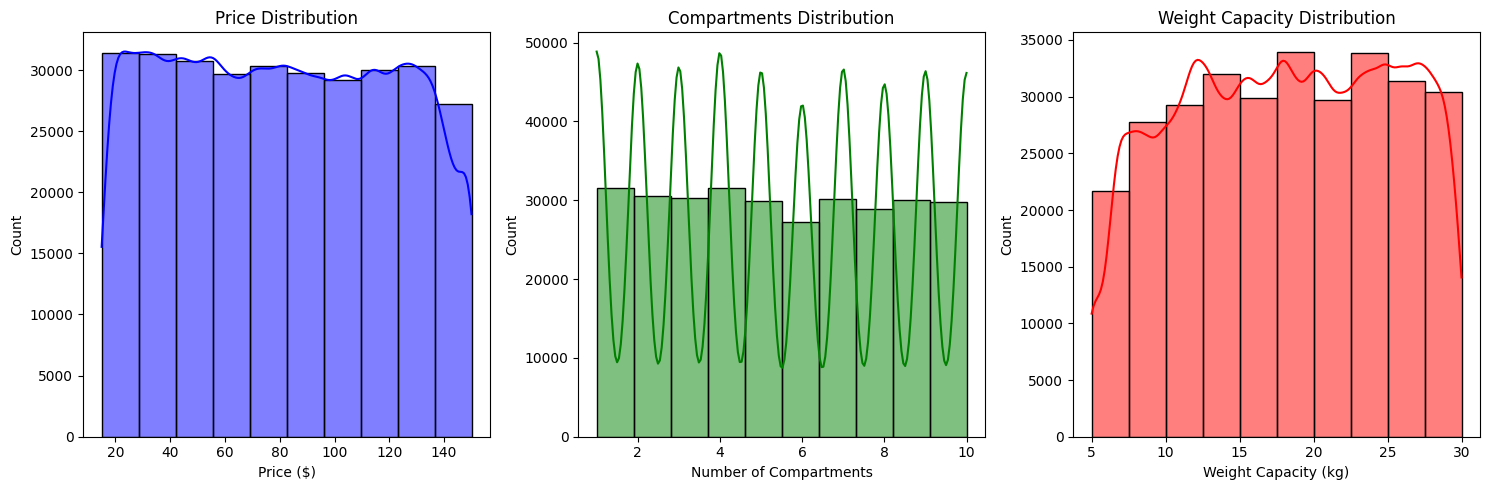

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.histplot(train_data["Price"], bins=10, kde=True, color='blue')
plt.title("Price Distribution")
plt.xlabel("Price ($)")

plt.subplot(1, 3, 2)
sns.histplot(train_data["Compartments"], bins=10, kde=True, color='green')
plt.title("Compartments Distribution")
plt.xlabel("Number of Compartments")

plt.subplot(1, 3, 3)
sns.histplot(train_data["Weight Capacity (kg)"], bins=10, kde=True, color='red')
plt.title("Weight Capacity Distribution")
plt.xlabel("Weight Capacity (kg)")

plt.tight_layout()
plt.show()

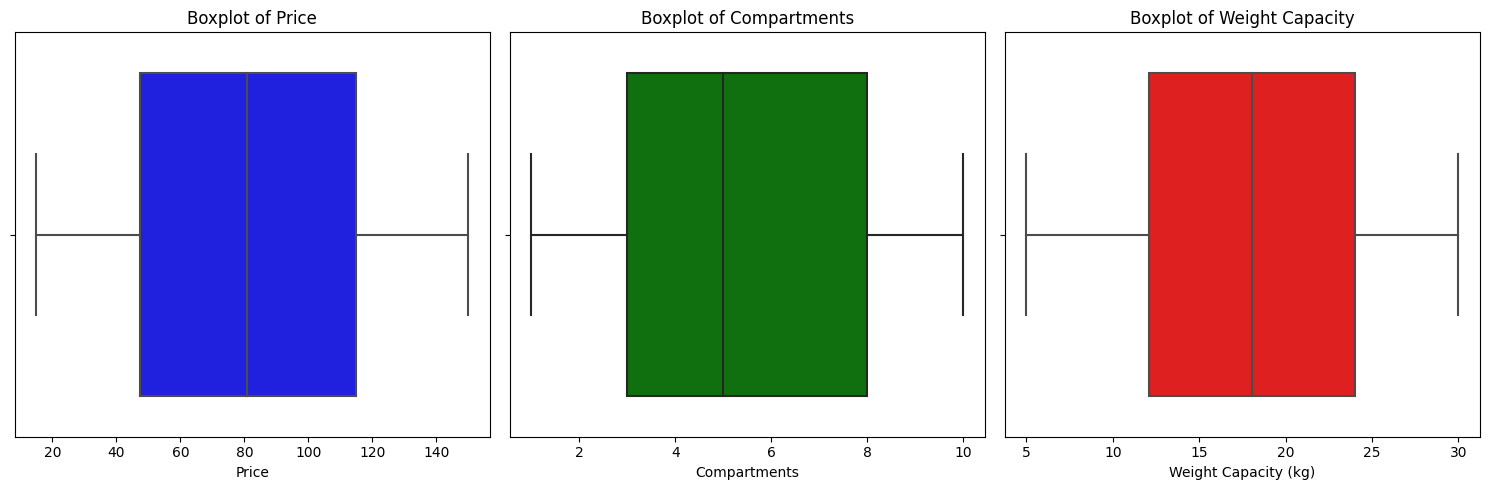

In [38]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x=train_data["Price"], color='blue')
plt.title("Boxplot of Price")

plt.subplot(1, 3, 2)
sns.boxplot(x=train_data["Compartments"], color='green')
plt.title("Boxplot of Compartments")

plt.subplot(1, 3, 3)
sns.boxplot(x=train_data["Weight Capacity (kg)"], color='red')
plt.title("Boxplot of Weight Capacity")

plt.tight_layout()
plt.show()

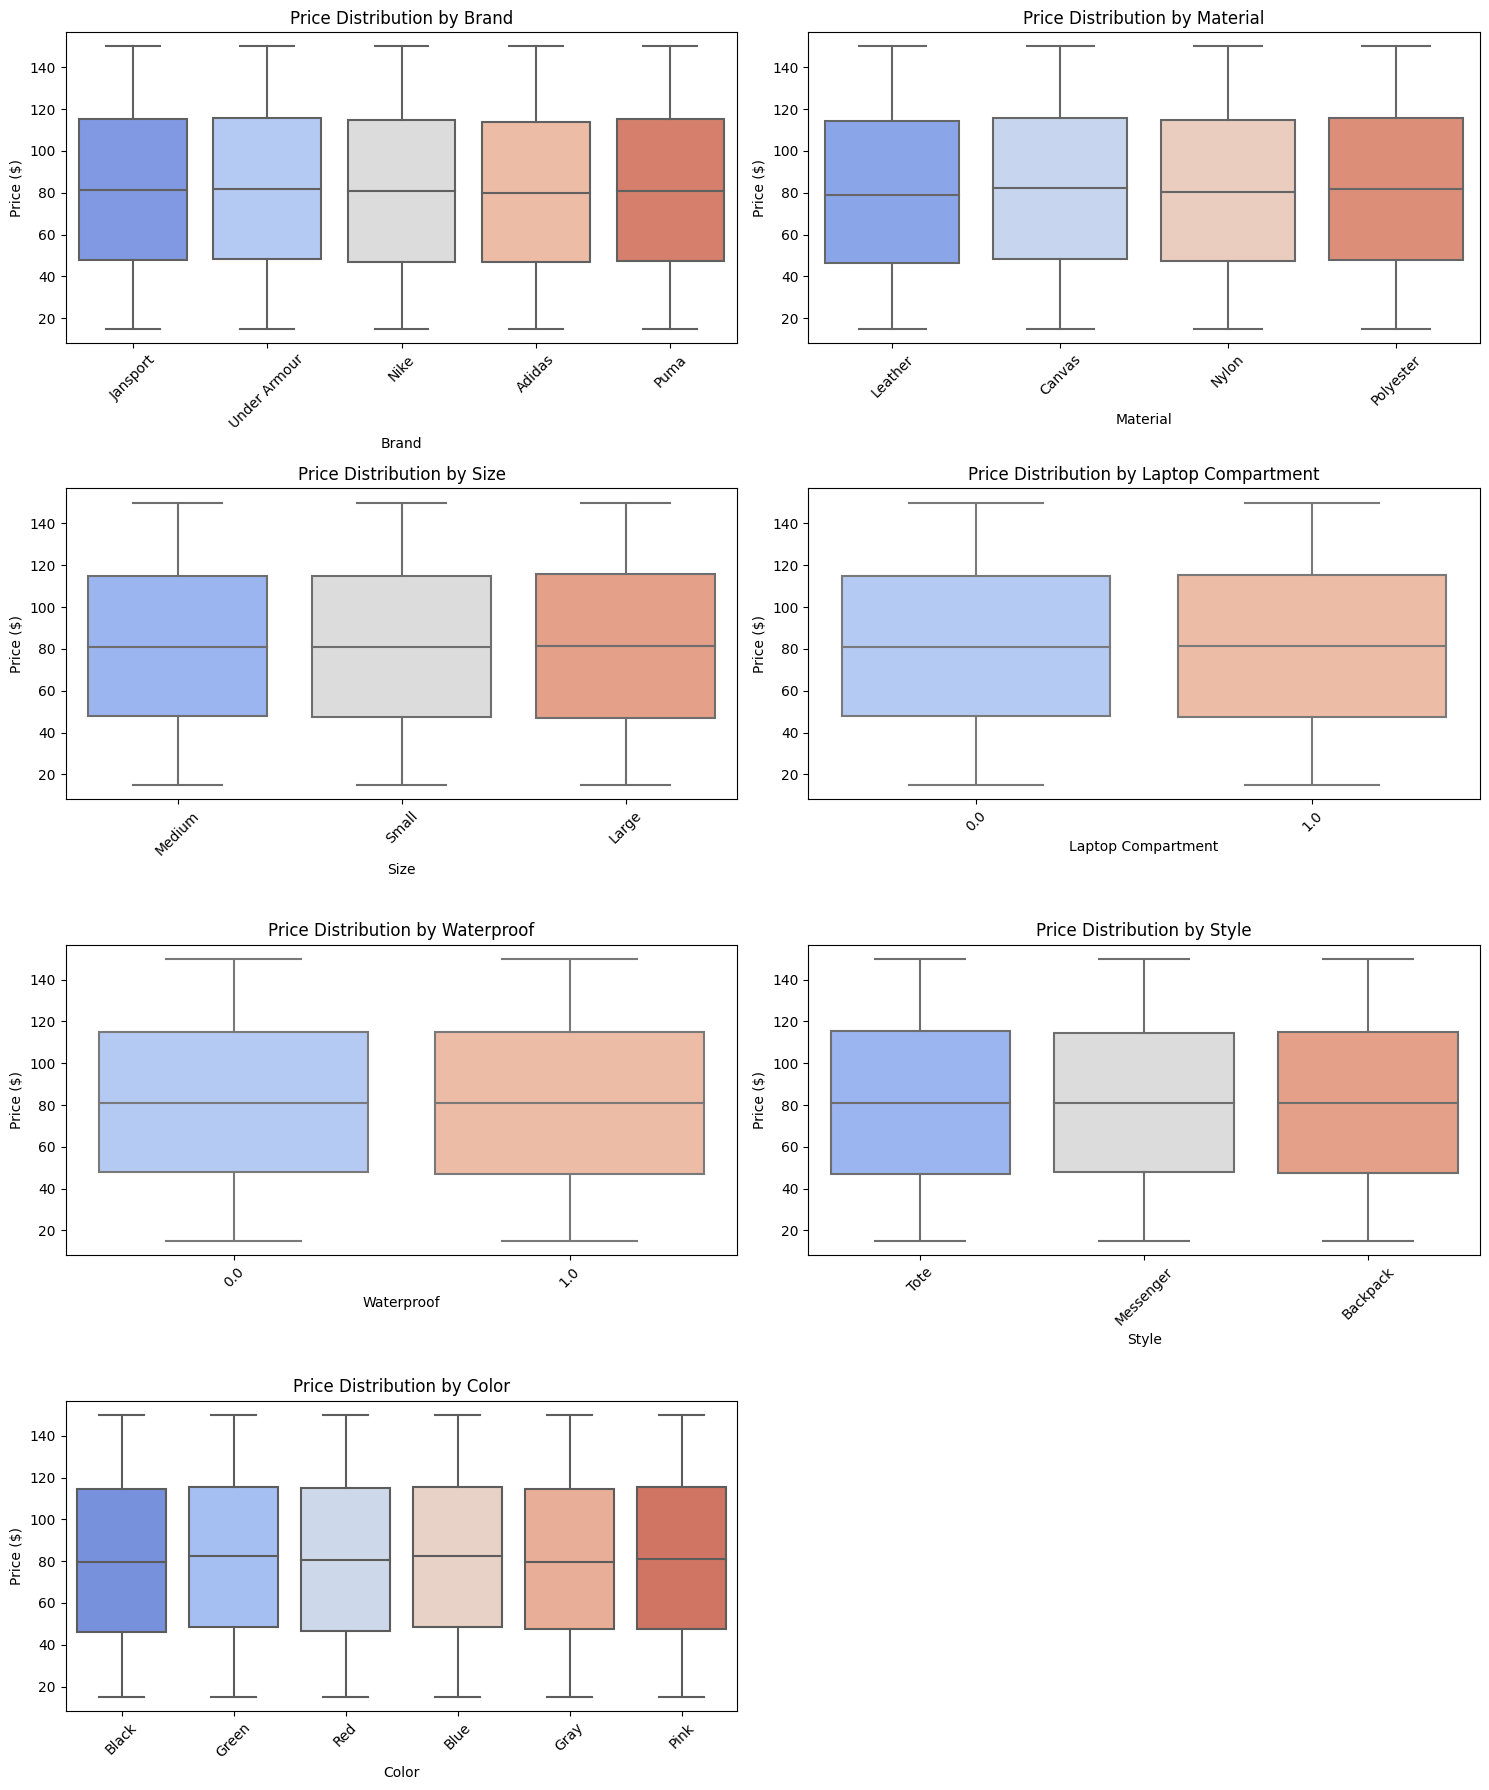

In [39]:
categorical_features = ["Brand", "Material", "Size", "Laptop Compartment", "Waterproof", "Style", "Color"]
plt.figure(figsize=(15, 18))

for i, col in enumerate(categorical_features, 1):
    plt.subplot(4, 2, i)
    sns.boxplot(x=train_data[col], y=train_data["Price"], palette="coolwarm")
    plt.xticks(rotation=45)
    plt.ylabel("Price ($)")
    plt.title(f"Price Distribution by {col}")

plt.tight_layout()

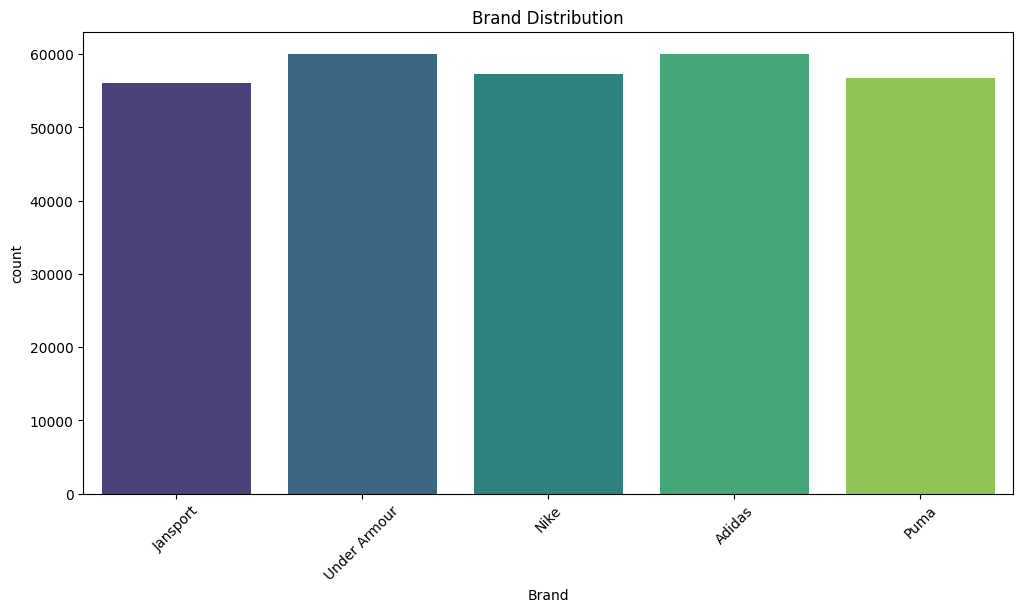

In [40]:
plt.figure(figsize=(12, 6))
sns.countplot(x='Brand', data=train_data, palette='viridis')
plt.title('Brand Distribution')
plt.xticks(rotation=45)
plt.show()

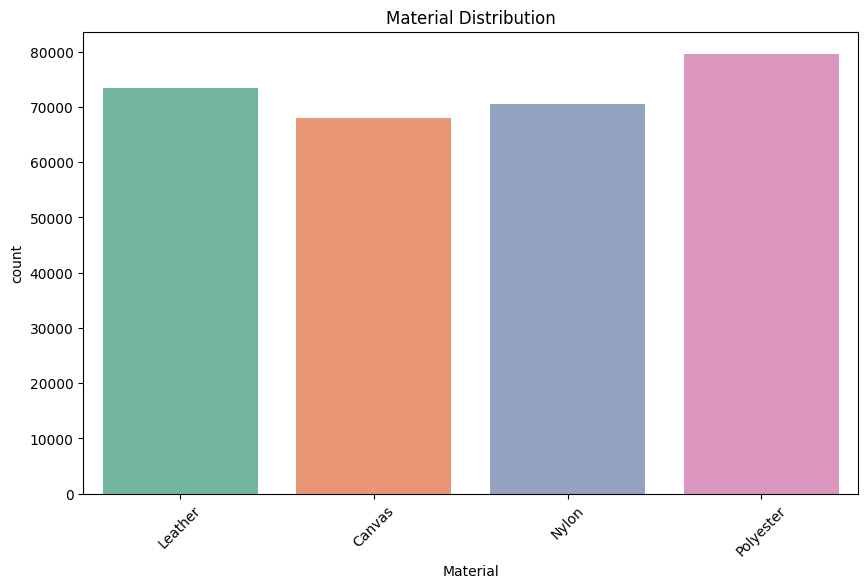

In [41]:
plt.figure(figsize=(10, 6))
sns.countplot(x='Material', data=train_data, palette='Set2')
plt.title('Material Distribution')
plt.xticks(rotation=45)
plt.show()

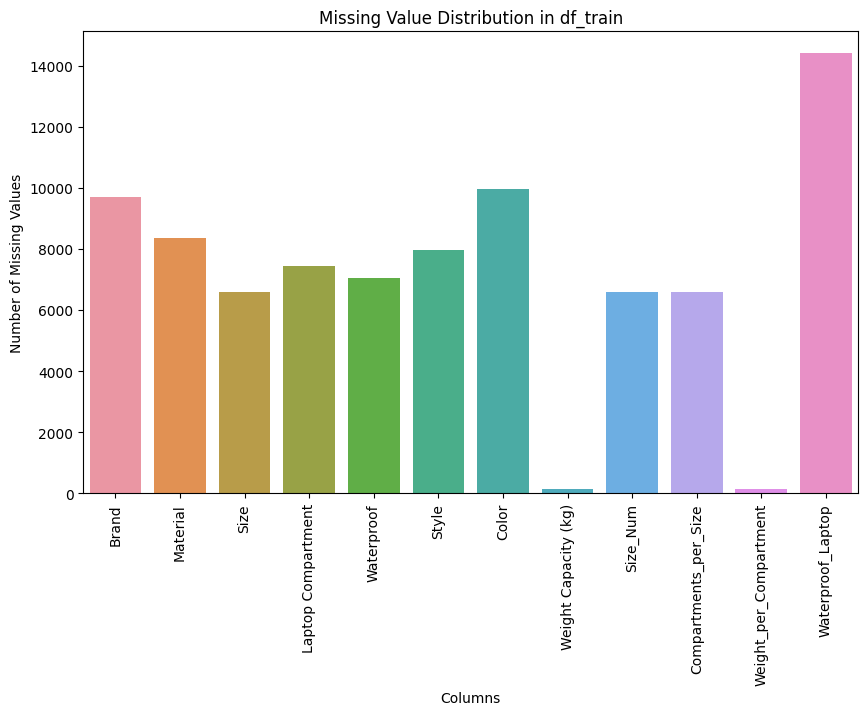

In [42]:
missing_data = train_data.isnull().sum()
missing_data = missing_data[missing_data > 0] 

if not missing_data.empty:
    plt.figure(figsize=(10, 6))
    sns.barplot(x=missing_data.index, y=missing_data.values)
    plt.title('Missing Value Distribution in df_train')
    plt.xlabel('Columns')
    plt.ylabel('Number of Missing Values')
    plt.xticks(rotation=90)
    plt.show()
else:
    print("No missing values in the dataset.")

## Feature Engineering (part 01)


In [16]:
# from sklearn.preprocessing import LabelEncoder

# categorical_features = ['Brand', 'Material', 'Size', 'Laptop Compartment', 
#                         'Waterproof', 'Style', 'Color']

# le = LabelEncoder()
# for col in categorical_features:
#     train_data[col] = le.fit_transform(train_data[col])
#     test_data[col] = le.transform(test_data[col])  # Transform using train labels


## Feature Engineering (part 02)


In [46]:
# Define categorical columns
cat = ['Brand', 'Material', 'Size', 'Compartments', 'Laptop Compartment',
       'Waterproof', 'Style', 'Color']

# Convert categorical columns to category type
train_data[cat] = train_data[cat].fillna('None').astype('category')
test_data[cat] = test_data[cat].fillna('None').astype('category')

# Fill missing values for Weight Capacity (kg)
median_weight = train_data['Weight Capacity (kg)'].median()
train_data['Weight Capacity (kg)'] = train_data['Weight Capacity (kg)'].fillna(median_weight).astype('float64')
test_data['Weight Capacity (kg)'] = test_data['Weight Capacity (kg)'].fillna(median_weight).astype('float64')

# Convert Weight Capacity (kg) categorical properly (directly to category, no string conversion)
train_data['Weight Capacity (kg) categorical'] = train_data['Weight Capacity (kg)'].fillna(median_weight).astype('category')
test_data['Weight Capacity (kg) categorical'] = test_data['Weight Capacity (kg)'].fillna(median_weight).astype('category')


In [47]:
print(train_data.dtypes)

Brand                               category
Material                            category
Size                                category
Compartments                        category
Laptop Compartment                  category
Waterproof                          category
Style                               category
Color                               category
Weight Capacity (kg)                 float64
Price                                float64
Size_Num                             float64
Compartments_per_Size                float64
Weight_per_Compartment               float64
Waterproof_Laptop                    float64
Is_Durable_Material                    int64
Is_Lightweight_Material                int64
Luxury_Material                        int64
Professional_Style                     int64
Casual_Style                           int64
Is_Premium_Brand                       int64
Is_Budget_Brand                        int64
Is_Small                               int64
Is_Medium 

In [48]:
test_data.dtypes

Brand                               category
Material                            category
Size                                category
Compartments                        category
Laptop Compartment                  category
Waterproof                          category
Style                               category
Color                               category
Weight Capacity (kg)                 float64
Size_Num                             float64
Compartments_per_Size                float64
Weight_per_Compartment               float64
Waterproof_Laptop                    float64
Is_Durable_Material                    int64
Is_Lightweight_Material                int64
Luxury_Material                        int64
Professional_Style                     int64
Casual_Style                           int64
Is_Premium_Brand                       int64
Is_Budget_Brand                        int64
Is_Small                               int64
Is_Medium                              int64
Is_Large  

In [19]:
print(train_data.head())

          Brand Material    Size Compartments Laptop Compartment Waterproof  \
0      Jansport  Leather  Medium          7.0                1.0        0.0   
1      Jansport   Canvas   Small         10.0                1.0        1.0   
2  Under Armour  Leather   Small          2.0                1.0        0.0   
3          Nike    Nylon   Small          8.0                1.0        0.0   
4        Adidas   Canvas  Medium          1.0                1.0        1.0   

       Style  Color  Weight Capacity (kg)      Price  ...  \
0       Tote  Black             11.611723  112.15875  ...   
1  Messenger  Green             27.078537   68.88056  ...   
2  Messenger    Red             16.643760   39.17320  ...   
3  Messenger  Green             12.937220   80.60793  ...   
4  Messenger  Green             17.749338   86.02312  ...   

   Is_Lightweight_Material  Luxury_Material  Professional_Style  Casual_Style  \
0                        0                1                   1             0

In [20]:
print(test_data.head())

    Brand Material    Size Compartments Laptop Compartment Waterproof  \
0    Puma  Leather   Small          2.0                0.0        0.0   
1    Nike   Canvas  Medium          7.0                0.0        1.0   
2  Adidas   Canvas   Large          9.0                0.0        1.0   
3  Adidas    Nylon   Large          1.0                1.0        0.0   
4    None    Nylon   Large          2.0                1.0        1.0   

       Style  Color  Weight Capacity (kg)  Size_Num  ...  \
0       Tote  Green             20.671147       1.0  ...   
1   Backpack  Green             13.564105       2.0  ...   
2  Messenger   Blue             11.809799       3.0  ...   
3  Messenger  Green             18.477036       3.0  ...   
4       Tote  Black              9.907953       3.0  ...   

   Is_Lightweight_Material  Luxury_Material  Professional_Style  Casual_Style  \
0                        0                1                   1             0   
1                        1            

## Split

In [21]:
from sklearn.model_selection import train_test_split

X = train_data.drop(columns=['Price'])
y = train_data['Price']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


## first phase models

In [ ]:
y = df_train['Price'] 
df_train = df_train.drop(['Price'],axis=1)
X = df_train
X_test = df_test

In [ ]:
# train_data = pd.get_dummies(train_data, columns=categorical_features, drop_first=True)
# test_data = pd.get_dummies(test_data, columns=categorical_features, drop_first=True)


In [18]:
from sklearn.model_selection import train_test_split

X = train_data.drop(columns=['id', 'Price'])  # Features
y = train_data['Price']  # Target variable

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


### RandomForestRegressor

In [19]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predictions
y_pred = rf_model.predict(X_val)

# Evaluate model
rmse = mean_squared_error(y_val, y_pred, squared=False)
print(f"Random Forest RMSE: {rmse}")


Random Forest RMSE: 40.16176094968915


In [20]:
test_preds = rf_model.predict(test_data.drop(columns=['id']))

# Save submission file
submission = pd.DataFrame({'id': test_data['id'], 'Price': test_preds})
submission.to_csv('submission.csv', index=False)

print("Submission file saved!")


Submission file saved!


### LGBMRegressor

In [22]:
import lightgbm as lgb

lgb_model = lgb.LGBMRegressor(objective='regression', metric='rmse', n_estimators=500)
lgb_model.fit(X_train, y_train)

y_pred_lgb = lgb_model.predict(X_val)
rmse_lgb = mean_squared_error(y_val, y_pred_lgb, squared=False)
print(f"LightGBM RMSE: {rmse_lgb}")


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003942 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 291
[LightGBM] [Info] Number of data points in the train set: 240000, number of used features: 9
[LightGBM] [Info] Start training from score 81.448481
LightGBM RMSE: 39.00108092279037


In [23]:
test_preds = lgb_model.predict(test_data.drop(columns=['id']))

# Save submission file
submission = pd.DataFrame({'id': test_data['id'], 'Price': test_preds})
submission.to_csv('submission2.csv', index=False)

print("Submission file saved!")


Submission file saved!


### XGBRegressor

In [24]:
import xgboost as xgb

xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=500,
    learning_rate=0.05,
    max_depth=7,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_val)

rmse_xgb = mean_squared_error(y_val, y_pred_xgb, squared=False)
print(f"XGBoost RMSE: {rmse_xgb}")


XGBoost RMSE: 39.083965123965854


In [25]:
test_preds = xgb_model.predict(test_data.drop(columns=['id']))

# Save submission file
submission = pd.DataFrame({'id': test_data['id'], 'Price': test_preds})
submission.to_csv('submission3.csv', index=False)

print("Submission file saved!")


Submission file saved!


### CatBoostRegressor

In [27]:
from catboost import CatBoostRegressor

cat_model = CatBoostRegressor(
    iterations=500,
    learning_rate=0.05,
    depth=7,
    loss_function='RMSE',
    verbose=False,
    random_seed=42
)

cat_model.fit(X_train, y_train)
y_pred_cat = cat_model.predict(X_val)

rmse_cat = mean_squared_error(y_val, y_pred_cat, squared=False)
print(f"CatBoost RMSE: {rmse_cat}")


CatBoost RMSE: 38.94543031974821


In [28]:
test_preds = cat_model.predict(test_data.drop(columns=['id']))

# Save submission file
submission = pd.DataFrame({'id': test_data['id'], 'Price': test_preds})
submission.to_csv('submission4.csv', index=False)

print("Submission file saved!")


Submission file saved!


### H2OAutoML

In [29]:
import h2o
from h2o.automl import H2OAutoML

h2o.init()

h2o_train = h2o.H2OFrame(pd.concat([X_train, y_train], axis=1))
h2o_val = h2o.H2OFrame(pd.concat([X_val, y_val], axis=1))

aml = H2OAutoML(max_models=10, seed=42)
aml.train(y='Price', training_frame=h2o_train)

lb = aml.leaderboard
best_model = aml.leader
h2o_pred = best_model.predict(h2o.H2OFrame(X_val)).as_data_frame().values.flatten()

rmse_h2o = mean_squared_error(y_val, h2o_pred, squared=False)
print(f"H2O AutoML Best Model RMSE: {rmse_h2o}")


Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.25" 2024-10-15; OpenJDK Runtime Environment (build 11.0.25+9-post-Ubuntu-1ubuntu122.04); OpenJDK 64-Bit Server VM (build 11.0.25+9-post-Ubuntu-1ubuntu122.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.10/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpuyvllxpz
  JVM stdout: /tmp/tmpuyvllxpz/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpuyvllxpz/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.6
H2O_cluster_version_age:,3 months and 1 day
H2O_cluster_name:,H2O_from_python_unknownUser_ajgnmv
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.500 Gb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%
H2O AutoML Best Model RMSE: 38.927854728379245


/usr/local/lib/python3.10/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


In [30]:
test_preds = cat_model.predict(test_data.drop(columns=['id']))

# Save submission file
submission = pd.DataFrame({'id': test_data['id'], 'Price': test_preds})
submission.to_csv('submission5.csv', index=False)

print("Submission file saved!")


Submission file saved!


### Stack

In [31]:
from sklearn.ensemble import StackingRegressor

stacking_model = StackingRegressor(
    estimators=[
        ('xgb', xgb_model),
        ('lgbm', lgb_model),
        ('cat', cat_model)
    ],
    final_estimator=xgb.XGBRegressor(n_estimators=300, learning_rate=0.05, random_state=42)
)

stacking_model.fit(X_train, y_train)
y_pred_stack = stacking_model.predict(X_val)

rmse_stack = mean_squared_error(y_val, y_pred_stack, squared=False)
print(f"Stacking RMSE: {rmse_stack}")


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003887 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 291
[LightGBM] [Info] Number of data points in the train set: 240000, number of used features: 9
[LightGBM] [Info] Start training from score 81.448481
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003735 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 291
[LightGBM] [Info] Number of data points in the train set: 192000, number of used features: 9
[LightGBM] [Info] Start training from score 81.459186
[LightGBM] [Warning] Found w

In [32]:
test_preds = stacking_model.predict(test_data.drop(columns=['id']))

# Save submission file
submission = pd.DataFrame({'id': test_data['id'], 'Price': test_preds})
submission.to_csv('submission6.csv', index=False)

print("Submission file saved!")


Submission file saved!


Next Steps to Improve Accuracy

Feature Engineering
Try interaction features (multiplying/dividing related features).
Use polynomial features if relationships are non-linear.
Experiment with embedding techniques if you have categorical features.


Hyperparameter Tuning
Use Optuna or GridSearchCV to fine-tune models.
Reduce learning rate and increase iterations for boosting models.
Try different regularization settings (lambda, alpha for XGB/LGBM).

Stacking Improvements
Instead of simple averaging, use meta-model stacking (e.g., using Ridge Regression or another model to learn from predictions).
Try blending with weighted averaging based on individual model performance.

Handling Outliers
Check for extreme values that might be distorting predictions.
Use log-transformations if target values are skewed.

Feature Selection
Remove irrelevant or noisy features.
Use SHAP values to understand feature importance.

Cross-validation Strategy
Ensure you are using Time Series Split or K-Fold CV properly.
Avoid data leakage by ensuring test data is not influencing training.

In [ ]:
# train_data["Brand_Material"] = train_data["Brand"] * train_data["Material"]
# test_data["Brand_Material"] = test_data["Brand"] * test_data["Material"]

# train_data["Size_Compartments"] = train_data["Size"] * train_data["Compartments"]
# test_data["Size_Compartments"] = test_data["Size"] * test_data["Compartments"]


## Second phase

### LGBM

In [49]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Define target and features
X = train_data.drop(columns=['Price'])
y = train_data['Price']

# Split data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Train LightGBM
lgb_model = lgb.LGBMRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=7,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

lgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], eval_metric='rmse')

# Predictions
y_pred_lgb = lgb_model.predict(X_val)
rmse_lgb = mean_squared_error(y_val, y_pred_lgb, squared=False)
print(f"LightGBM RMSE: {rmse_lgb}")


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.038199 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14212
[LightGBM] [Info] Number of data points in the train set: 240000, number of used features: 24
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 81.448481
LightGBM RMSE: 38.99548201315091


In [70]:
test_preds = lgb_model.predict(test_data)

# Save submission file
submission = pd.DataFrame({'id': test_data['id'], 'Price': test_preds})
submission.to_csv('submission6.csv', index=False)

print("Submission file saved!")


ValueError: Number of features of the model must match the input. Model n_features_ is 24 and input n_features is 23

In [52]:
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Train XGBoost Model
xgb_model = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=7,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    enable_categorical=True  # Allow categorical features in XGBoost
)

xgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], eval_metric='rmse', early_stopping_rounds=50, verbose=50)

# Predictions
y_pred_xgb = xgb_model.predict(X_val)
rmse_xgb = mean_squared_error(y_val, y_pred_xgb, squared=False)
print(f"XGBoost RMSE: {rmse_xgb}")


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:38.94375
[50]	validation_0-rmse:38.91973
[100]	validation_0-rmse:38.91843
[136]	validation_0-rmse:38.92280
XGBoost RMSE: 38.91596923312194


# OPTUNA

In [22]:
# import optuna
# import pandas as pd
# import numpy as np
# import lightgbm as lgb
# import catboost as cb
# import xgboost as xgb
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import mean_squared_error
# from sklearn.preprocessing import LabelEncoder
# from sklearn.impute import SimpleImputer

# # Load dataset
# train_df = pd.read_csv("/kaggle/input/playground-series-s5e2/train.csv")
# test_df = pd.read_csv("/kaggle/input/playground-series-s5e2/test.csv")

# # Identify categorical and numerical columns
# categorical_cols = train_df.select_dtypes(include=["object"]).columns.tolist()
# numerical_cols = train_df.select_dtypes(include=["int64", "float64"]).columns.drop("Price", errors="ignore").tolist()

# # Handle missing values
# imputer = SimpleImputer(strategy="median")  
# train_df[numerical_cols] = imputer.fit_transform(train_df[numerical_cols])
# test_df[numerical_cols] = imputer.transform(test_df[numerical_cols])

# # Encode categorical variables properly
# label_encoders = {}
# for col in categorical_cols:
#     le = LabelEncoder()
#     train_df[col] = le.fit_transform(train_df[col])
#     test_df[col] = le.transform(test_df[col])
#     label_encoders[col] = le

# # Also keep categorical dtype for LightGBM
# for col in categorical_cols:
#     train_df[col] = train_df[col].astype("category")
#     test_df[col] = test_df[col].astype("category")

# # Define features and target variable
# X = train_df.drop(columns=["Price"])
# y = train_df["Price"]

# # Split data
# X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# # Optuna objective function
# def objective(trial):
#     model_type = trial.suggest_categorical("model", ["lightgbm", "catboost", "xgboost"])
    
#     if model_type == "lightgbm":
#         params = {
#             "objective": "regression",
#             "metric": "rmse",
#             "boosting_type": "gbdt",
#             "num_leaves": trial.suggest_int("num_leaves", 20, 150),
#             "max_depth": trial.suggest_int("max_depth", 3, 12),
#             "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
#             "n_estimators": trial.suggest_int("n_estimators", 500, 3000),
#             "min_child_samples": trial.suggest_int("min_child_samples", 10, 50),
#             "subsample": trial.suggest_float("subsample", 0.6, 1.0),
#             "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
#             "reg_lambda": trial.suggest_float("reg_lambda", 1e-3, 10.0, log=True),
#             "reg_alpha": trial.suggest_float("reg_alpha", 1e-3, 10.0, log=True)
#         }
#         model = lgb.LGBMRegressor(**params)

#     elif model_type == "catboost":
#         params = {
#             "iterations": trial.suggest_int("iterations", 500, 3000),
#             "depth": trial.suggest_int("depth", 3, 10),
#             "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
#             "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-5, 10, log=True),
#             "random_strength": trial.suggest_float("random_strength", 0.1, 2.0),
#             "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 1.0),
#             "border_count": trial.suggest_int("border_count", 32, 255),
#             "verbose": 0,
#             "eval_metric": "RMSE"
#         }
#         model = cb.CatBoostRegressor(**params)

#     else:  # XGBoost
#         params = {
#             "objective": "reg:squarederror",
#             "eval_metric": "rmse",
#             "booster": trial.suggest_categorical("booster", ["gbtree", "dart"]),
#             "max_depth": trial.suggest_int("max_depth", 3, 12),
#             "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
#             "n_estimators": trial.suggest_int("n_estimators", 500, 3000),
#             "gamma": trial.suggest_float("gamma", 0, 10),
#             "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
#             "subsample": trial.suggest_float("subsample", 0.6, 1.0),
#             "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
#         }
#         model = xgb.XGBRegressor(**params)

#     # Train with early stopping
#     if model_type == "lightgbm":
#         model.fit(
#             X_train, y_train,
#             eval_set=[(X_valid, y_valid)],
#             eval_names=["validation"],  
#             callbacks=[lgb.early_stopping(100, verbose=False)]
#         )
#     elif model_type == "catboost":
#         model.fit(
#             X_train, y_train,
#             eval_set=(X_valid, y_valid),  
#             early_stopping_rounds=100,
#             verbose=False
#         )
#     else:
#         model.fit(
#             X_train, y_train,
#             eval_set=[(X_valid, y_valid)],
#             early_stopping_rounds=100,
#             verbose=False
#         )

#     preds = model.predict(X_valid)

#     # Evaluate
#     rmse = mean_squared_error(y_valid, preds, squared=False)
#     return rmse





# # Run Optuna optimization
# study = optuna.create_study(direction="minimize")
# study.optimize(objective, n_trials=50)

# # Best model
# print("Best model:", study.best_params)

# # Train final model using best params
# best_model_type = study.best_params.pop("model")

# if best_model_type == "lightgbm":
#     final_model = lgb.LGBMRegressor(**study.best_params)
# elif best_model_type == "catboost":
#     final_model = cb.CatBoostRegressor(**study.best_params)
# else:
#     final_model = xgb.XGBRegressor(**study.best_params)

# # Train the best model on full training data
# final_model.fit(X, y)

# # Make predictions on test set
# test_preds = final_model.predict(test_df)

# # Create submission file
# submission = pd.DataFrame({"id": test_df["id"], "Price": test_preds})
# submission.to_csv("Optuna_submission.csv", index=False)

# print("Submission file saved!")


### Catboost optuna

In [31]:
import optuna
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Load dataset
train_df = pd.read_csv("/kaggle/input/playground-series-s5e2/train.csv")
test_df = pd.read_csv("/kaggle/input/playground-series-s5e2/test.csv")

# Feature Engineering Function
def feature_engineering(data):
    # Fill missing values
    data['Brand'].fillna('Unknown', inplace=True)
    data['Material'].fillna('Unknown', inplace=True)
    data['Size'].fillna('Unknown', inplace=True)
    data['Compartments'].fillna(data['Compartments'].median(), inplace=True)
    data['Laptop Compartment'].fillna(0, inplace=True)
    data['Waterproof'].fillna(0, inplace=True)
    data['Style'].fillna('Unknown', inplace=True)
    data['Color'].fillna('Unknown', inplace=True)
    data['Weight Capacity (kg)'].fillna(data['Weight Capacity (kg)'].median(), inplace=True)

    # Convert 'Size' to numerical values
    size_mapping = {'Small': 1, 'Medium': 2, 'Large': 3}
    data['Size_Num'] = data['Size'].map(size_mapping).fillna(0).astype(int)

    # Ensure numeric columns are properly typed
    numeric_cols = ['Compartments', 'Weight Capacity (kg)', 'Size_Num']
    for col in numeric_cols:
        data[col] = pd.to_numeric(data[col], errors='coerce').fillna(data[col].median())

    data['Waterproof'] = pd.to_numeric(data['Waterproof'], errors='coerce').fillna(0)
    data['Laptop Compartment'] = pd.to_numeric(data['Laptop Compartment'], errors='coerce').fillna(0)

    # Create new features
    data['Compartments_per_Size'] = data['Compartments'] / (data['Size_Num'] + 1)  # Avoid division by zero
    data['Weight_per_Compartment'] = data['Weight Capacity (kg)'] / (data['Compartments'] + 1)
    data['Waterproof_Laptop'] = data['Waterproof'] * data['Laptop Compartment']

    # Binary Features
    data['Is_Durable_Material'] = data['Material'].apply(lambda x: 1 if x in ['Leather', 'Nylon'] else 0)
    data['Is_Lightweight_Material'] = data['Material'].apply(lambda x: 1 if x in ['Canvas', 'Nylon'] else 0)
    data['Luxury_Material'] = data['Material'].apply(lambda x: 1 if x == 'Leather' else 0)
    data['Professional_Style'] = data['Style'].apply(lambda x: 1 if x in ['Backpack', 'Messenger'] else 0)
    data['Casual_Style'] = data['Style'].apply(lambda x: 1 if x in ['Tote', 'Satchel'] else 0)
    data['Is_Premium_Brand'] = data['Brand'].apply(lambda x: 1 if x in ['Under Armour', 'Nike', 'Adidas'] else 0)
    data['Is_Budget_Brand'] = data['Brand'].apply(lambda x: 1 if x in ['Jansport', 'Puma'] else 0)
    data['Is_Small'] = data['Size'].apply(lambda x: 1 if x == 'Small' else 0)
    data['Is_Medium'] = data['Size'].apply(lambda x: 1 if x == 'Medium' else 0)
    data['Is_Large'] = data['Size'].apply(lambda x: 1 if x == 'Large' else 0)

    # Convert categorical columns to category type
    categorical_cols = ['Brand', 'Material', 'Size', 'Style', 'Color']
    for col in categorical_cols:
        data[col] = data[col].astype('category')

    return data

# Apply feature engineering
train_df = feature_engineering(train_df)
test_df = feature_engineering(test_df)

# Drop 'id' if present
if "id" in test_df.columns:
    test_ids = test_df["id"]
    test_df.drop(columns=["id"], inplace=True)

# Define features and target variable
X = train_df.drop(columns=["Price"])
y = train_df["Price"]

# Identify categorical features for CatBoost
categorical_features = X.select_dtypes(include=['category']).columns.tolist()

# Convert categorical feature names to indices
cat_feature_indices = [X.columns.get_loc(col) for col in categorical_features]

# Split data
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# Optuna Objective Function
def objective(trial):
    grow_policy = trial.suggest_categorical("grow_policy", ["Depthwise", "SymmetricTree"])
    
    # Ensure 'Ordered' boosting is not used with 'Depthwise' grow policy
    if grow_policy == "Depthwise":
        boosting_type = "Plain"  # Force "Plain" for Depthwise
    else:
        boosting_type = trial.suggest_categorical("boosting_type", ["Ordered", "Plain"])

    params = {
        "iterations": trial.suggest_int("iterations", 500, 3000),
        "depth": trial.suggest_int("depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-5, 10, log=True),
        "random_strength": trial.suggest_float("random_strength", 0.1, 2.0),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 1.0),
        "border_count": trial.suggest_int("border_count", 32, 255),
        "grow_policy": grow_policy,
        "boosting_type": boosting_type,  # Ensured compatibility
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
        "verbose": 0,
        "eval_metric": "RMSE"
    }
    
    model = CatBoostRegressor(**params)
    
    model.fit(
        X_train, y_train,
        eval_set=(X_valid, y_valid),
        cat_features=cat_feature_indices,  
        early_stopping_rounds=100,
        verbose=False
    )
    
    preds = model.predict(X_valid)
    rmse = mean_squared_error(y_valid, preds, squared=False)
    return rmse


# Run Optuna Optimization
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

# Best Model Parameters
print("Best model parameters:", study.best_params)

# Train Final Model
final_model = CatBoostRegressor(**study.best_params)

final_model.fit(X, y, cat_features=cat_feature_indices)  # Train on full data with categorical features

# Make Predictions on Test Set
test_preds = final_model.predict(test_df)

# Create Submission File
submission = pd.DataFrame({"id": test_ids, "Price": test_preds})
submission.to_csv("Optuna_CatBoost_submission.csv", index=False)

print("✅ Submission file saved!")


<ipython-input-31-716dc335e608>:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Brand'].fillna('Unknown', inplace=True)
<ipython-input-31-716dc335e608>:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using

Best model parameters: {'grow_policy': 'SymmetricTree', 'boosting_type': 'Ordered', 'iterations': 2616, 'depth': 10, 'learning_rate': 0.09170289965096959, 'l2_leaf_reg': 0.017058255484116595, 'random_strength': 1.3013049438391042, 'bagging_temperature': 0.05582895724253707, 'border_count': 185, 'min_data_in_leaf': 83}
0:	learn: 39.0365617	total: 88.1ms	remaining: 3m 50s
1:	learn: 39.0343334	total: 251ms	remaining: 5m 27s
2:	learn: 39.0317455	total: 446ms	remaining: 6m 28s
3:	learn: 39.0297545	total: 739ms	remaining: 8m 2s
4:	learn: 39.0271086	total: 1.06s	remaining: 9m 13s
5:	learn: 39.0259267	total: 1.23s	remaining: 8m 55s
6:	learn: 39.0250517	total: 1.32s	remaining: 8m 10s
7:	learn: 39.0243898	total: 1.39s	remaining: 7m 34s
8:	learn: 39.0237870	total: 1.52s	remaining: 7m 19s
9:	learn: 39.0233411	total: 1.61s	remaining: 7m
10:	learn: 39.0226238	total: 1.7s	remaining: 6m 42s
11:	learn: 39.0221194	total: 1.78s	remaining: 6m 25s
12:	learn: 39.0212482	total: 1.98s	remaining: 6m 36s
13:	le

CatBoostError: features data: pandas.DataFrame column 'Brand' has dtype 'category' but is not in  cat_features list

In [1]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Load dataset
train_df = pd.read_csv("/kaggle/input/playground-series-s5e2/train.csv")
test_df = pd.read_csv("/kaggle/input/playground-series-s5e2/test.csv")

# Feature Engineering Function
def feature_engineering(data):
    # Fill missing values
    data['Material'] = data['Material'].fillna('Unknown')
    data['Brand'] = data['Brand'].fillna('Unknown')
    data['Size'] = data['Size'].fillna('Unknown')
    data['Compartments'] = data['Compartments'].fillna(data['Compartments'].median())
    data['Laptop Compartment'] = data['Laptop Compartment'].fillna(0)
    data['Waterproof'] = data['Waterproof'].fillna(0)
    data['Style'] = data['Style'].fillna('Unknown')
    data['Color'] = data['Color'].fillna('Unknown')
    data['Weight Capacity (kg)'] = data['Weight Capacity (kg)'].fillna(data['Weight Capacity (kg)'].median())

    # Convert 'Size' to numerical values
    size_mapping = {'Small': 1, 'Medium': 2, 'Large': 3}
    data['Size_Num'] = data['Size'].map(size_mapping).fillna(0).astype(int)

    # Ensure numeric columns are properly formatted
    numeric_cols = ['Compartments', 'Weight Capacity (kg)', 'Size_Num']
    for col in numeric_cols:
        data[col] = pd.to_numeric(data[col], errors='coerce').fillna(data[col].median())

    data['Waterproof'] = pd.to_numeric(data['Waterproof'], errors='coerce').fillna(0).astype(int)
    data['Laptop Compartment'] = pd.to_numeric(data['Laptop Compartment'], errors='coerce').fillna(0).astype(int)

    # Create new features
    data['Compartments_per_Size'] = data['Compartments'] / (data['Size_Num'] + 1)  # Avoid division by zero
    data['Weight_per_Compartment'] = data['Weight Capacity (kg)'] / (data['Compartments'] + 1)
    data['Waterproof_Laptop'] = data['Waterproof'] * data['Laptop Compartment']

    # Binary Features
    data['Is_Durable_Material'] = data['Material'].apply(lambda x: 1 if x in ['Leather', 'Nylon'] else 0)
    data['Is_Lightweight_Material'] = data['Material'].apply(lambda x: 1 if x in ['Canvas', 'Nylon'] else 0)
    data['Luxury_Material'] = data['Material'].apply(lambda x: 1 if x == 'Leather' else 0)
    data['Professional_Style'] = data['Style'].apply(lambda x: 1 if x in ['Backpack', 'Messenger'] else 0)
    data['Casual_Style'] = data['Style'].apply(lambda x: 1 if x in ['Tote', 'Satchel'] else 0)
    data['Is_Premium_Brand'] = data['Brand'].apply(lambda x: 1 if x in ['Under Armour', 'Nike', 'Adidas'] else 0)
    data['Is_Budget_Brand'] = data['Brand'].apply(lambda x: 1 if x in ['Jansport', 'Puma'] else 0)
    data['Is_Small'] = data['Size'].apply(lambda x: 1 if x == 'Small' else 0)
    data['Is_Medium'] = data['Size'].apply(lambda x: 1 if x == 'Medium' else 0)
    data['Is_Large'] = data['Size'].apply(lambda x: 1 if x == 'Large' else 0)

    return data



train_df = feature_engineering(train_df)
test_df = feature_engineering(test_df)

# Extract and drop 'id' from both train and test data
test_ids = test_df["id"]
train_df.drop(columns=["id"], inplace=True)
test_df.drop(columns=["id"], inplace=True)  # Also drop from test data

# Define features and target variable
X = train_df.drop(columns=["Price"])
y = train_df["Price"]

# Convert categorical columns to string (DO NOT convert to 'category' dtype)
categorical_cols = ['Brand', 'Material', 'Size', 'Style', 'Color']
for col in categorical_cols:
    X[col] = X[col].astype(str)
    test_df[col] = test_df[col].astype(str)  # Keep as string, not category

# Identify categorical feature indices
cat_feature_indices = [X.columns.get_loc(col) for col in categorical_cols]


# Train Final Model with Best Parameters
final_model = CatBoostRegressor(
    grow_policy="SymmetricTree",
    boosting_type="Ordered",
    iterations=2616,
    depth=10,
    learning_rate=0.0917,
    l2_leaf_reg=0.0171,
    random_strength=1.3013,
    bagging_temperature=0.0558,
    border_count=185,
    min_data_in_leaf=83,
    verbose=0,
    eval_metric="RMSE"
)

# Train model (same as before)
final_model.fit(X, y, cat_features=cat_feature_indices)

# Make predictions (test_df now matches training data format)
test_preds = final_model.predict(test_df)

# Create Submission File
submission = pd.DataFrame({"id": test_ids, "Price": test_preds})
submission.to_csv("Optuna_CatBoost_submission.csv", index=False)

print("✅ Submission file saved successfully!")


✅ Submission file saved successfully!


In [1]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Load dataset
train_df = pd.read_csv("/kaggle/input/playground-series-s5e2/train.csv")
test_df = pd.read_csv("/kaggle/input/playground-series-s5e2/test.csv")

# Feature Engineering Function
def feature_engineering(data):
    # Fill missing values
    data['Material'] = data['Material'].fillna('Unknown')
    data['Brand'] = data['Brand'].fillna('Unknown')
    data['Size'] = data['Size'].fillna('Unknown')
    data['Compartments'] = data['Compartments'].fillna(data['Compartments'].median())
    data['Laptop Compartment'] = data['Laptop Compartment'].fillna(0)
    data['Waterproof'] = data['Waterproof'].fillna(0)
    data['Style'] = data['Style'].fillna('Unknown')
    data['Color'] = data['Color'].fillna('Unknown')
    data['Weight Capacity (kg)'] = data['Weight Capacity (kg)'].fillna(data['Weight Capacity (kg)'].median())

    # Convert 'Size' to numerical values
    size_mapping = {'Small': 1, 'Medium': 2, 'Large': 3}
    data['Size_Num'] = data['Size'].map(size_mapping).fillna(0).astype(int)

    # Ensure numeric columns are properly formatted
    numeric_cols = ['Compartments', 'Weight Capacity (kg)', 'Size_Num']
    for col in numeric_cols:
        data[col] = pd.to_numeric(data[col], errors='coerce').fillna(data[col].median())

    data['Waterproof'] = pd.to_numeric(data['Waterproof'], errors='coerce').fillna(0).astype(int)
    data['Laptop Compartment'] = pd.to_numeric(data['Laptop Compartment'], errors='coerce').fillna(0).astype(int)

    # Create new features
    data['Compartments_per_Size'] = data['Compartments'] / (data['Size_Num'] + 1)  # Avoid division by zero
    data['Weight_per_Compartment'] = data['Weight Capacity (kg)'] / (data['Compartments'] + 1)
    data['Waterproof_Laptop'] = data['Waterproof'] * data['Laptop Compartment']

    # Binary Features
    data['Is_Durable_Material'] = data['Material'].apply(lambda x: 1 if x in ['Leather', 'Nylon'] else 0)
    data['Is_Lightweight_Material'] = data['Material'].apply(lambda x: 1 if x in ['Canvas', 'Nylon'] else 0)
    data['Luxury_Material'] = data['Material'].apply(lambda x: 1 if x == 'Leather' else 0)
    data['Professional_Style'] = data['Style'].apply(lambda x: 1 if x in ['Backpack', 'Messenger'] else 0)
    data['Casual_Style'] = data['Style'].apply(lambda x: 1 if x in ['Tote', 'Satchel'] else 0)
    data['Is_Premium_Brand'] = data['Brand'].apply(lambda x: 1 if x in ['Under Armour', 'Nike', 'Adidas'] else 0)
    data['Is_Budget_Brand'] = data['Brand'].apply(lambda x: 1 if x in ['Jansport', 'Puma'] else 0)
    data['Is_Small'] = data['Size'].apply(lambda x: 1 if x == 'Small' else 0)
    data['Is_Medium'] = data['Size'].apply(lambda x: 1 if x == 'Medium' else 0)
    data['Is_Large'] = data['Size'].apply(lambda x: 1 if x == 'Large' else 0)

    return data



train_df = feature_engineering(train_df)
test_df = feature_engineering(test_df)

# Extract and drop 'id' from both train and test data
test_ids = test_df["id"]
train_df.drop(columns=["id"], inplace=True)
test_df.drop(columns=["id"], inplace=True)  # Also drop from test data

# Define features and target variable
X = train_df.drop(columns=["Price"])
y = train_df["Price"]

# Convert categorical columns to string (DO NOT convert to 'category' dtype)
categorical_cols = ['Brand', 'Material', 'Size', 'Style', 'Color']
for col in categorical_cols:
    X[col] = X[col].astype(str)
    test_df[col] = test_df[col].astype(str)  # Keep as string, not category

# Identify categorical feature indices
cat_feature_indices = [X.columns.get_loc(col) for col in categorical_cols]


cat_model = CatBoostRegressor(
    iterations=500,
    learning_rate=0.05,
    depth=7,
    loss_function='RMSE',
    verbose=False,
    random_seed=42
)

cat_model.fit(X, y, cat_features=cat_feature_indices)
y_pred_cat = cat_model.predict(test_df)

# Create Submission File
submission = pd.DataFrame({"id": test_ids, "Price": y_pred_cat})
submission.to_csv("Featured_CatBoost_submission.csv", index=False)

print("✅ Submission file saved successfully!")

✅ Submission file saved successfully!


In [7]:
from sklearn.metrics import mean_squared_error

# Predict on training data
y_train_pred = cat_model.predict(X)

# Calculate RMSE
rmse = mean_squared_error(y, y_train_pred, squared=False)
print(f"Training RMSE: {rmse:.4f}")


Training RMSE: 38.9452


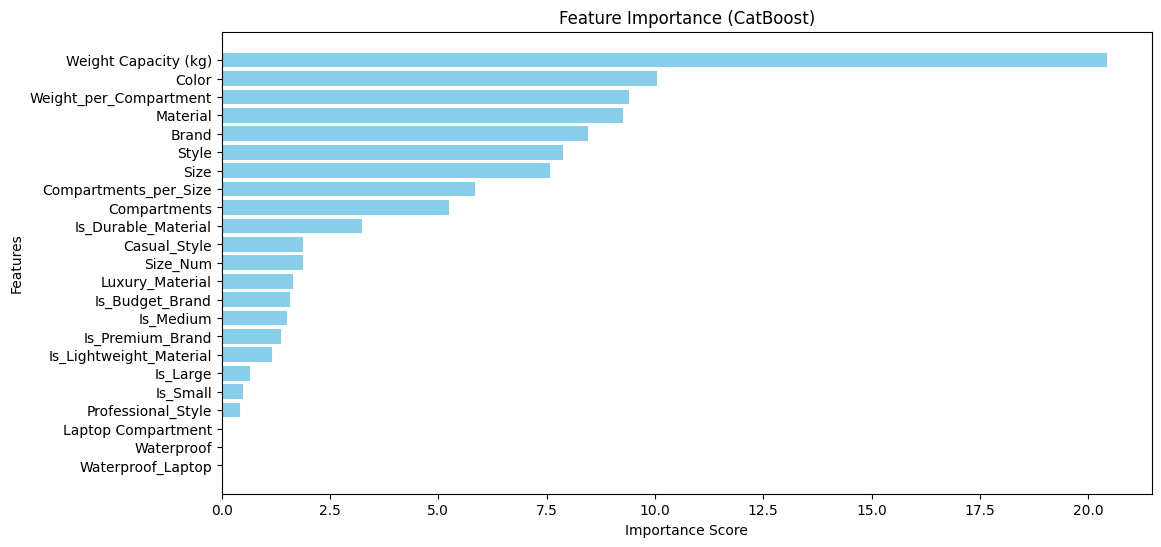

In [2]:
import matplotlib.pyplot as plt

# Get feature importance
feature_importance = cat_model.get_feature_importance()
feature_names = X.columns

# Create a DataFrame for visualization
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
importance_df = importance_df.sort_values(by="Importance", ascending=False)

# Plot feature importance
plt.figure(figsize=(12, 6))
plt.barh(importance_df["Feature"], importance_df["Importance"], color="skyblue")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.title("Feature Importance (CatBoost)")
plt.gca().invert_yaxis()
plt.show()

In [3]:
# Print feature importance in descending order
for feature, importance in zip(importance_df["Feature"], importance_df["Importance"]):
    print(f"{feature}: {importance:.4f}")


Weight Capacity (kg): 20.4405
Color: 10.0523
Weight_per_Compartment: 9.3978
Material: 9.2613
Brand: 8.4547
Style: 7.8883
Size: 7.5864
Compartments_per_Size: 5.8503
Compartments: 5.2355
Is_Durable_Material: 3.2414
Casual_Style: 1.8765
Size_Num: 1.8708
Luxury_Material: 1.6549
Is_Budget_Brand: 1.5703
Is_Medium: 1.5173
Is_Premium_Brand: 1.3668
Is_Lightweight_Material: 1.1657
Is_Large: 0.6536
Is_Small: 0.4962
Professional_Style: 0.4196
Laptop Compartment: 0.0000
Waterproof: 0.0000
Waterproof_Laptop: 0.0000


In [1]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

# Load dataset
train_df = pd.read_csv("/kaggle/input/playground-series-s5e2/train.csv")
test_df = pd.read_csv("/kaggle/input/playground-series-s5e2/test.csv")

# Feature Engineering Function
def feature_engineering(data):
    # Fill missing values
    data['Material'] = data['Material'].fillna('Unknown')
    data['Brand'] = data['Brand'].fillna('Unknown')
    data['Size'] = data['Size'].fillna('Unknown')
    data['Compartments'] = data['Compartments'].fillna(data['Compartments'].median())
    data['Style'] = data['Style'].fillna('Unknown')
    data['Color'] = data['Color'].fillna('Unknown')
    data['Weight Capacity (kg)'] = data['Weight Capacity (kg)'].fillna(data['Weight Capacity (kg)'].median())

    # Convert 'Size' to numerical values
    size_mapping = {'Small': 1, 'Medium': 2, 'Large': 3}
    data['Size_Num'] = data['Size'].map(size_mapping).fillna(0).astype(int)

    # Ensure numeric columns are properly formatted
    numeric_cols = ['Compartments', 'Weight Capacity (kg)', 'Size_Num']
    for col in numeric_cols:
        data[col] = pd.to_numeric(data[col], errors='coerce').fillna(data[col].median())

    # Create new features (improved transformations)
    data['Log_Compartments'] = np.log1p(data['Compartments'])  # Log transformation
    data['Log_Weight_Capacity'] = np.log1p(data['Weight Capacity (kg)'])
    
    # Interaction feature
    data['Brand_Style'] = data['Brand'] + "_" + data['Style']

    return data

# Apply feature engineering
train_df = feature_engineering(train_df)
test_df = feature_engineering(test_df)

# Extract test IDs and drop 'id' column
test_ids = test_df["id"]
train_df.drop(columns=["id"], inplace=True)
test_df.drop(columns=["id"], inplace=True)

# Define features and target variable
X = train_df.drop(columns=["Price"])
y = train_df["Price"]

# Drop low-importance features
low_importance_features = ["Laptop Compartment", "Waterproof", "Waterproof_Laptop", 
                           "Is_Small", "Is_Large", "Professional_Style"]
X.drop(columns=[col for col in low_importance_features if col in X.columns], inplace=True)
test_df.drop(columns=[col for col in low_importance_features if col in test_df.columns], inplace=True)

# Define categorical columns
categorical_cols = ['Brand', 'Material', 'Size', 'Style', 'Color', 'Brand_Style']

# Encode categorical features
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    test_df[col] = le.transform(test_df[col])
    label_encoders[col] = le  # Store encoders for consistency

# Split data
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# Define models
catboost = CatBoostRegressor(iterations=1000, depth=7, learning_rate=0.05, random_seed=42, verbose=0, cat_features=categorical_cols)
xgb = XGBRegressor(n_estimators=1000, learning_rate=0.05, max_depth=7, random_state=42)
lgbm = LGBMRegressor(n_estimators=1000, learning_rate=0.05, max_depth=7, random_state=42)

# Stacking Regressor
stacking_model = StackingRegressor(
    estimators=[("catboost", catboost), ("xgb", xgb), ("lgbm", lgbm)],
    final_estimator=CatBoostRegressor(iterations=500, learning_rate=0.05, depth=6, verbose=0),
    passthrough=True
)

# Train model
stacking_model.fit(X_train, y_train)

# Predictions
y_pred = stacking_model.predict(X_valid)
test_preds = stacking_model.predict(test_df)

# Evaluate performance
rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
print(f"Validation RMSE: {rmse}")

# Save submission
submission = pd.DataFrame({"id": test_ids, "Price": test_preds})
submission.to_csv("stacking_submission.csv", index=False)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004797 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 586
[LightGBM] [Info] Number of data points in the train set: 240000, number of used features: 11
[LightGBM] [Info] Start training from score 81.448481
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003215 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 586
[LightGBM] [Info] Number of data points in the train set: 192000, number of used features: 11
[LightGBM] [Info] Start training from score 81.459186
[LightGBM] [Warning] Found

In [1]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

# Load data
train_df = pd.read_csv("/kaggle/input/playground-series-s5e2/train.csv")
test_df = pd.read_csv("/kaggle/input/playground-series-s5e2/test.csv")
test_ids = test_df["id"]

# Enhanced Feature Engineering
def feature_engineering(data):
    # Convert boolean-like columns
    for col in ['Laptop Compartment', 'Waterproof']:
        data[col] = data[col].replace({'Yes': 1, 'No': 0}).fillna(0).astype(int)
    
    # Handle categorical missing values
    for col in ['Material', 'Brand', 'Size', 'Style', 'Color']:
        data[col] = data[col].fillna('Unknown')
    
    # Numeric features
    data['Compartments'] = data['Compartments'].fillna(data['Compartments'].median())
    data['Weight Capacity (kg)'] = data['Weight Capacity (kg)'].fillna(data['Weight Capacity (kg)'].median())

    # Size mapping
    size_mapping = {'Small': 1, 'Medium': 2, 'Large': 3}
    data['Size_Num'] = data['Size'].map(size_mapping).fillna(0).astype(int)

    # Feature interactions
    data['Compartments_per_Size'] = data['Compartments'] / (data['Size_Num'] + 1e-5)
    data['Weight_per_Compartment'] = data['Weight Capacity (kg)'] / (data['Compartments'] + 1)
    data['Brand_Style'] = data['Brand'] + "_" + data['Style']
    
    return data

# Apply feature engineering
train_df = feature_engineering(train_df)
test_df = feature_engineering(test_df)

# Prepare data
X = train_df.drop(columns=["id", "Price"])
y = train_df["Price"]
test_df = test_df.drop(columns=["id"])

# Define categorical columns
categorical_cols = ['Brand', 'Material', 'Size', 'Style', 'Color', 'Brand_Style']

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), categorical_cols)
    ],
    remainder='passthrough'
)

# Process data and maintain as numpy array
X_processed = preprocessor.fit_transform(X)
test_processed = preprocessor.transform(test_df)

# Convert categorical features to integers
num_cat_features = len(categorical_cols)
X_processed = X_processed.astype(object)
test_processed = test_processed.astype(object)

X_processed[:, :num_cat_features] = X_processed[:, :num_cat_features].astype(int)
test_processed[:, :num_cat_features] = test_processed[:, :num_cat_features].astype(int)

# Convert remaining features to float
X_processed[:, num_cat_features:] = X_processed[:, num_cat_features:].astype(float)
test_processed[:, num_cat_features:] = test_processed[:, num_cat_features:].astype(float)

# Initialize models
models = {
    'cat': CatBoostRegressor(
        iterations=1200,
        depth=7,
        learning_rate=0.05,
        cat_features=list(range(num_cat_features)),
        random_seed=42,
        verbose=0
    ),
    'xgb': XGBRegressor(
        n_estimators=1200,
        learning_rate=0.03,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    ),
    'lgbm': LGBMRegressor(
        n_estimators=1200,
        learning_rate=0.03,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )
}

# Cross-validation setup
NUM_FOLDS = 5
train_preds = np.zeros(len(X))
test_preds = np.zeros((test_processed.shape[0], NUM_FOLDS))
oof_scores = []

kf = KFold(n_splits=NUM_FOLDS, shuffle=True, random_state=42)
for fold, (train_idx, val_idx) in enumerate(kf.split(X_processed)):
    print(f"\nFold {fold + 1}/{NUM_FOLDS}")
    
    # Split data using numpy array
    X_train, X_val = X_processed[train_idx], X_processed[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    # Train models
    fold_preds = {}
    for name, model in models.items():
        model.fit(X_train, y_train)
        fold_preds[name] = model.predict(X_val)
    
    # Blend predictions
    blend_val = 0.5*fold_preds['cat'] + 0.3*fold_preds['xgb'] + 0.2*fold_preds['lgbm']
    train_preds[val_idx] = blend_val
    
    # Calculate fold RMSE
    fold_rmse = np.sqrt(mean_squared_error(y_val, blend_val))
    oof_scores.append(fold_rmse)
    print(f"Fold RMSE: {fold_rmse:.4f}")
    
    # Generate test predictions
    test_blend = 0.5*models['cat'].predict(test_processed) + \
                 0.3*models['xgb'].predict(test_processed) + \
                 0.2*models['lgbm'].predict(test_processed)
    test_preds[:, fold] = test_blend

# Final metrics
print(f"\nAverage OOF RMSE: {np.mean(oof_scores):.4f}")
print(f"OOF RMSE Std: {np.std(oof_scores):.4f}")

# Create submission
final_test_preds = test_preds.mean(axis=1)
submission = pd.DataFrame({"id": test_ids, "Price": final_test_preds})
submission.to_csv("final_ensemble_submission.csv", index=False)
print("\n✅ Submission saved!")

<ipython-input-1-1e22b59e90b1>:20: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data[col] = data[col].replace({'Yes': 1, 'No': 0}).fillna(0).astype(int)
<ipython-input-1-1e22b59e90b1>:20: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data[col] = data[col].replace({'Yes': 1, 'No': 0}).fillna(0).astype(int)
<ipython-input-1-1e22b59e90b1>:20: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in


Fold 1/5
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019942 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 620
[LightGBM] [Info] Number of data points in the train set: 240000, number of used features: 13
[LightGBM] [Info] Start training from score 81.448481
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Fold RMSE: 38.9362

Fold 2/5
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003836 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info]

In [ ]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import optuna

# Load dataset
train_df = pd.read_csv("/kaggle/input/playground-series-s5e2/train.csv")
test_df = pd.read_csv("/kaggle/input/playground-series-s5e2/test.csv")

# Feature Engineering Function (Optimized)
def feature_engineering(data):
    # Fill missing values
    fill_values = {
        'Material': 'Unknown',
        'Brand': 'Unknown',
        'Size': 'Unknown',
        'Compartments': data['Compartments'].median(),
        'Laptop Compartment': 0,
        'Waterproof': 0,
        'Style': 'Unknown',
        'Color': 'Unknown',
        'Weight Capacity (kg)': data['Weight Capacity (kg)'].median()
    }
    data = data.fillna(fill_values)

    # Convert binary features
    for col in ['Laptop Compartment', 'Waterproof']:
        data[col] = data[col].replace({'Yes': 1, 'No': 0}).astype(int)

    # Size encoding
    size_mapping = {'Small': 1, 'Medium': 2, 'Large': 3}
    data['Size_Num'] = data['Size'].map(size_mapping).fillna(0).astype(int)

    # Feature interactions
    data['Capacity_per_Size'] = data['Weight Capacity (kg)'] / (data['Size_Num'] + 1)
    data['Compartments_per_kg'] = data['Compartments'] / (data['Weight Capacity (kg)'] + 1)
    
    # Material flags
    material_groups = {
        'Durable': ['Leather', 'Nylon'],
        'Lightweight': ['Canvas', 'Polyester']
    }
    for group, materials in material_groups.items():
        data[f'Material_{group}'] = data['Material'].isin(materials).astype(int)
    
    return data

# Apply feature engineering
train_df = feature_engineering(train_df)
test_df = feature_engineering(test_df)

# Prepare data
X = train_df.drop(columns=["id", "Price"])
y = train_df["Price"]
test_ids = test_df["id"]
test_df = test_df.drop(columns=["id"])

# Convert categorical columns
categorical_cols = ['Brand', 'Material', 'Size', 'Style', 'Color']
for col in categorical_cols:
    X[col] = X[col].astype(str)
    test_df[col] = test_df[col].astype(str)

# Identify categorical indices
cat_indices = [X.columns.get_loc(col) for col in categorical_cols]

# Hyperparameter Optimization with Optuna
def optimize_hyperparameters(X, y, cat_indices):
    def objective(trial):
        params = {
            'iterations': trial.suggest_int('iterations', 800, 2000),
            'depth': trial.suggest_int('depth', 6, 10),
            'learning_rate': trial.suggest_float('lr', 0.01, 0.1, log=True),
            'l2_leaf_reg': trial.suggest_float('l2', 1, 10),
            'random_strength': trial.suggest_float('random_strength', 0.1, 10),
            'bootstrap_type': 'Bernoulli',
            'subsample': trial.suggest_float('subsample', 0.6, 0.95),
            'min_data_in_leaf': trial.suggest_int('min_data', 1, 50)
        }
        
        scores = []
        kf = KFold(n_splits=5, shuffle=True, random_state=42)
        for train_idx, val_idx in kf.split(X):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
            
            model = CatBoostRegressor(**params, verbose=0)
            model.fit(X_train, y_train, cat_features=cat_indices)
            preds = model.predict(X_val)
            scores.append(mean_squared_error(y_val, preds, squared=False))
        
        return np.mean(scores)
    
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=50)
    return study.best_params

# Run optimization
best_params = optimize_hyperparameters(X, y, cat_indices)

# Final model training with KFold
final_preds = np.zeros(len(test_df))
kf = KFold(n_splits=5, shuffle=True, random_state=42)
oof_preds = np.zeros(len(X))
rmse_scores = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
    print(f"Training Fold {fold+1}/5")
    
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    model = CatBoostRegressor(
        **best_params,
        cat_features=cat_indices,
        random_seed=42,
        verbose=0
    )
    model.fit(X_train, y_train)
    
    # Validation
    val_preds = model.predict(X_val)
    fold_rmse = mean_squared_error(y_val, val_preds, squared=False)
    rmse_scores.append(fold_rmse)
    oof_preds[val_idx] = val_preds
    
    # Test predictions
    final_preds += model.predict(test_df) / kf.n_splits

print(f"\nMean OOF RMSE: {np.mean(rmse_scores):.4f}")
print(f"OOF Std: {np.std(rmse_scores):.4f}")

# Create submission
submission = pd.DataFrame({"id": test_ids, "Price": final_preds})
submission.to_csv("Optimized_CatBoost_Submission.csv", index=False)
print("✅ Submission saved!")

<ipython-input-1-193c2700447f>:30: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data[col] = data[col].replace({'Yes': 1, 'No': 0}).astype(int)
<ipython-input-1-193c2700447f>:30: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data[col] = data[col].replace({'Yes': 1, 'No': 0}).astype(int)
<ipython-input-1-193c2700447f>:30: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behav